# Multi-label learning, part 1

In this notebook, we present 2, out 4 in total, approaches for multi-label Machine Learning problems, using the `scikit-learn` and `scikit-multilearn` libraries, for the most part.

The problems we address correspond to the Natural Language Processing domain, where documents are represented using tf-idf vectors, and the modeling approach utilizes the Naive Bayes algorithm.

Our dataset consists of movie overview documents and was taken from [Kaggle](https://www.kaggle.com/tmdb/tmdb-movie-metadata).

Our approaches consist of the following solutions:
- __Binary relevance__
- __Random K-Labelsets (RAkEL)__
- Label Power-Set
- Classsifier Chains

For more details and explanations the authors created a corresponding report in which the key results are further exlained and analyzed.

Happy reading and feel free to contact us for any further details.

## Exploratory Data Analysis

Firstly, we begin by exploring our dataset.

We import needed libraries and set the font size for `matplotlib` to 12 for improved readability.

In [1]:
import json
import pandas as pd
import os
import matplotlib.pyplot as plt
plt.rc('font', size=12)

We create a function for loading our dataset.

In [2]:
def load_movies(path):
    df = pd.read_csv(path)
    df['release_date'] = pd.to_datetime(df['release_date']).apply(lambda x: x.date())
    json_columns = ['genres', 'keywords', 'production_countries', 'production_companies', 'spoken_languages']
    for column in json_columns:
        df[column] = df[column].apply(json.loads)
    return df

We explore the contents of our dataset folder.

In [3]:
dataset_folder = 'TMDB_5000/'

os.listdir(dataset_folder)

['tmdb_5000_credits.csv', 'tmdb_5000_movies.csv']

We load our dataset, keep relevant columns and discard rows containing null or empty data.

In [4]:
df_movies = load_movies(dataset_folder + 'tmdb_5000_movies.csv')

columns_of_interest = ['id', 'title', 'genres', 'overview']
df_movies = df_movies[columns_of_interest]
df_movies = df_movies[df_movies['genres'].str.len() != 0]
df_movies = df_movies[df_movies['overview'].notnull()].reset_index(drop=True)

df_movies.head()

,id,title,genres,overview
0,19995,Avatar,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...","In the 22nd century, a paraplegic Marine is di..."
1,285,Pirates of the Caribbean: At World's End,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...","Captain Barbossa, long believed to be dead, ha..."
2,206647,Spectre,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",A cryptic message from Bond’s past sends him o...
3,49026,The Dark Knight Rises,"[{'id': 28, 'name': 'Action'}, {'id': 80, 'nam...",Following the death of District Attorney Harve...
4,49529,John Carter,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...","John Carter is a war-weary, former military ca..."


We calculate genre statistics.

In [5]:
genres_count = {}

for index, row in df_movies.iterrows():
    for genre in row['genres']:
        genre_name = genre['name']
        genres_count[genre_name] = genres_count[genre_name] + 1 if genre_name in genres_count else 1
        
genres_count = dict(sorted(genres_count.items(), key=lambda x:x[1], reverse=False))

In [6]:
genres_count

{'TV Movie': 8,
 'Foreign': 34,
 'Western': 82,
 'Documentary': 108,
 'War': 144,
 'Music': 185,
 'History': 197,
 'Animation': 234,
 'Mystery': 348,
 'Fantasy': 424,
 'Family': 513,
 'Horror': 519,
 'Science Fiction': 535,
 'Crime': 696,
 'Adventure': 790,
 'Romance': 894,
 'Action': 1154,
 'Thriller': 1274,
 'Comedy': 1722,
 'Drama': 2296}

And plot them.

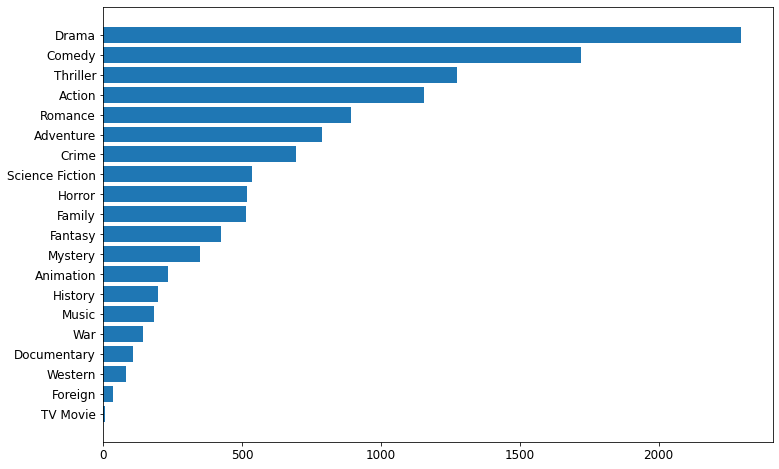

In [7]:
plt.figure(figsize=(12,8))
plt.barh(list(genres_count.keys()), genres_count.values())
plt.show()

## Data Preprocessing

Secondly, we prepare our data to be put through our models. Since we are dealing with text data, we will use the `gensim` and `nltk` libraries for this task..

### Tokenization

We import the needed libraries.

In [8]:
import gensim
import nltk

from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *

stemmer = SnowballStemmer('english')
lemmatizer = WordNetLemmatizer()
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Ceyx\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

We begin by creating a function to tokenize our data. This function will also filter stopwords and discard rare tokens with less than 3 appearances.

In [9]:
def tokenize(text):
    result = []
    for token in simple_preprocess(text):
        if token not in STOPWORDS and len(token) > 3:
            result.append(stemmer.stem(lemmatizer.lemmatize(token,'v')))
    return result

Let's take a look at a sample and an example of the tokenization function.

In [10]:
movie = df_movies.loc[255]
movie, movie['overview']

(id                                                      13700
 title                                       Home on the Range
 genres      [{'id': 16, 'name': 'Animation'}, {'id': 10751...
 overview    When a greedy outlaw schemes to take possessio...
 Name: 255, dtype: object,
 'When a greedy outlaw schemes to take possession of the "Patch Of Heaven" dairy farm, three determined cows, a karate-kicking stallion and a colorful corral of critters join forces to save their home. The stakes are sky-high as this unlikely animal alliance risk their hides and match wits with a mysterious band of bad guys.')

In [11]:
tokenize(movie['overview'])

['greedi',
 'outlaw',
 'scheme',
 'possess',
 'patch',
 'heaven',
 'dairi',
 'farm',
 'determin',
 'cow',
 'karat',
 'kick',
 'stallion',
 'color',
 'corral',
 'critter',
 'join',
 'forc',
 'save',
 'home',
 'stake',
 'high',
 'unlik',
 'anim',
 'allianc',
 'risk',
 'hide',
 'match',
 'wit',
 'mysteri',
 'band',
 'guy']

We apply the tokenization function to our entire dataset.

In [12]:
movie_overviews = df_movies['overview'].map(tokenize)
movie_overviews

0       [centuri, parapleg, marin, dispatch, moon, pan...
1       [captain, barbossa, long, believ, dead, come, ...
2       [cryptic, messag, bond, past, send, trail, unc...
3       [follow, death, district, attorney, harvey, de...
4       [john, carter, weari, militari, captain, inexp...
                              ...                        
4767    [adam, secur, guard, travel, california, phili...
4768    [mariachi, want, play, guitar, carri, famili, ...
4769    [newlyw, coupl, honeymoon, upend, arriv, respe...
4770    [sign, seal, deliv, introduc, dedic, quartet, ...
4771    [second, grade, brian, herzling, crush, draw, ...
Name: overview, Length: 4772, dtype: object

### Bag-of-Words & TfIdf

Next, we will transform our dataset tokens into token indices.

In [13]:
from gensim.corpora import Dictionary
from gensim.models import TfidfModel
from gensim.matutils import corpus2dense

We filter common tokens appearing more than 50% of the time and rare tokens that appear only ten times. We also keep a maximum of 100,000 tokens.

In [14]:
dictionary = Dictionary(movie_overviews)
dictionary.filter_extremes(no_below=10, no_above=0.5, keep_n=100000)

Let's take a look at an example of the token-to-index process.

In [15]:
bow_corpus = [dictionary.doc2bow(doc) for doc in movie_overviews]
bow_corpus[255]

[(26, 1),
 (57, 1),
 (113, 1),
 (129, 1),
 (132, 1),
 (199, 1),
 (226, 1),
 (235, 1),
 (241, 1),
 (288, 1),
 (319, 1),
 (450, 1),
 (471, 1),
 (509, 1),
 (536, 1),
 (566, 1),
 (775, 1),
 (1173, 1),
 (1297, 1),
 (1341, 1),
 (1435, 1),
 (1436, 1),
 (1437, 1),
 (1438, 1)]

We transform all tokens into indices.

In [16]:
tfidf_corpus = TfidfModel(bow_corpus)[bow_corpus]
tfidf_corpus = corpus2dense(tfidf_corpus, num_terms=100000, num_docs=len(tfidf_corpus)).T
tfidf_corpus.shape

(4772, 100000)

## Multi-label genre overview classification

Thirdly, we apply our multi-label algorithms for predicting the genre of movies, based on their summary.

### Binary relevance

We begin with the Binary Relevance algorithm and import needed libraries.

In [17]:
import numpy as np
from skmultilearn.problem_transform import BinaryRelevance
# from sklearn.multioutput import MultiOutputClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from joblib import dump, load
from sklearn import metrics

We prepare the inputs and the targets.

In [18]:
genres = list(reversed(list(genres_count)))

x, y = [], []
for index, row in df_movies.iterrows():
    x.append(tfidf_corpus[index])
    ohe = np.zeros(len(genres))
    y_indices = [genres.index(genre['name']) for genre in row['genres']]
    ohe[y_indices] = 1
    y.append(ohe)
y = np.matrix(y)

Before we proceed, let's take a look at the correlation between genres.

Since we have 20 different labels and various correlations, we cannot expect our models to yield great results in terms of classification metrics. We can however expect a considerable approximation, which is our main goal.

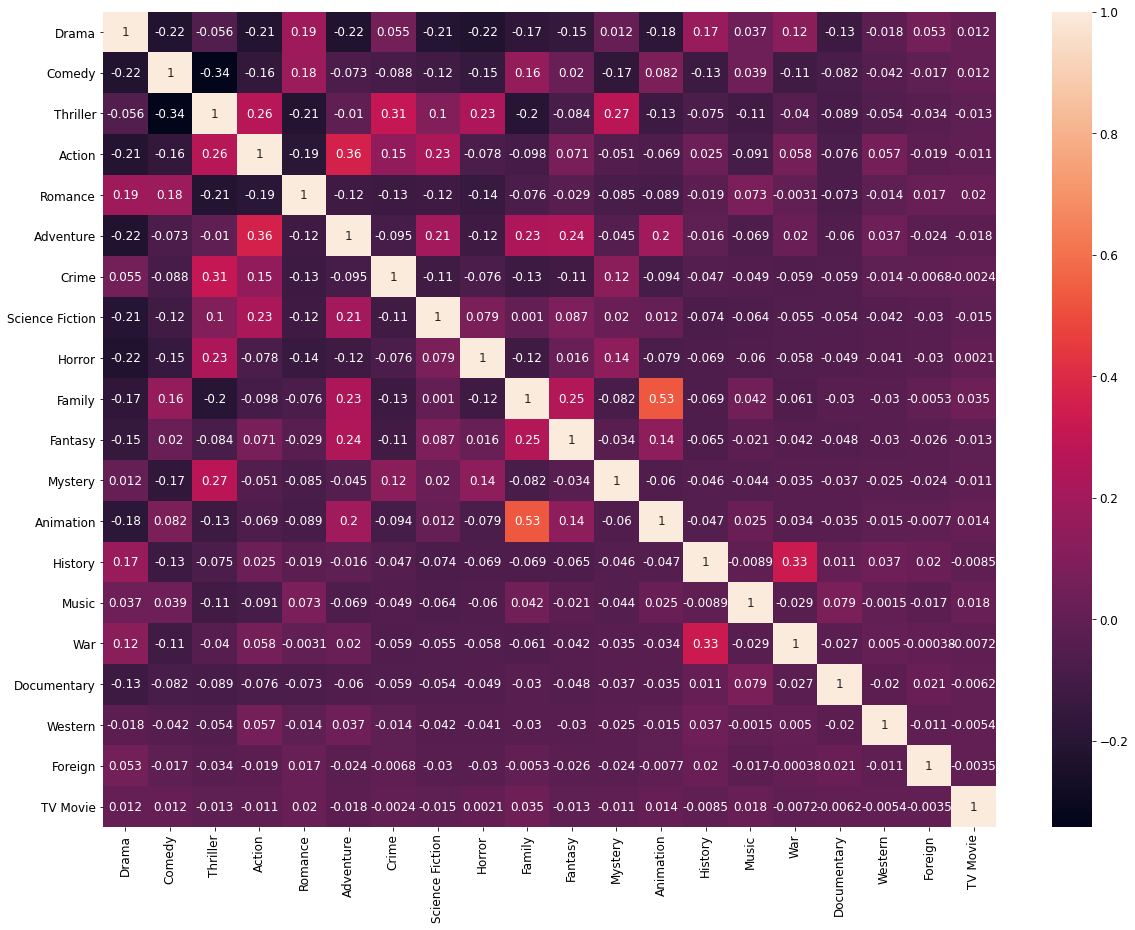

In [19]:
import seaborn as sns
keys = list(reversed(list(genres_count.keys())))
plt.figure(figsize=(20,15))
sns.heatmap(np.corrcoef(y.T), annot=True,
            xticklabels=keys, yticklabels=keys);

We split our data into training and test set.

In [20]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.15)
len(y_train), len(y_test)

(4056, 716)

We train our Binary Relevance Naive Bayes model.

In [22]:
# clf = MultiOutputClassifier(GaussianNB()).fit(x_train, y_train)
clf = BinaryRelevance(GaussianNB()).fit(x_train, y_train)
# dump(clf, 'multioutput_naivebayes.model')

In [23]:
# clf = load('multioutput_naivebayes.model')

Let's take a look at an example and see how well our model performs.

In [24]:
df_movies.loc[0, 'overview']

'In the 22nd century, a paraplegic Marine is dispatched to the moon Pandora on a unique mission, but becomes torn between following orders and protecting an alien civilization.'

Given the overview presented above, we can see our model has performed quite decently.

In [43]:
# [keys[i] for i in np.where(clf.predict([tfidf_corpus[0]]) == 1)[1]]
[keys[i] for i in np.where(clf.predict([tfidf_corpus[0]]).todense() == 1)[1]]

['Thriller', 'Action', 'Adventure', 'Science Fiction']

We make a prediction on our entire test set.

In [44]:
y_test_predicted = clf.predict(x_test)

And calculate the various metrics.

In [45]:
print('Hamming:', metrics.hamming_loss(y_test, y_test_predicted))
print('Accuracy:', metrics.accuracy_score(y_test, y_test_predicted))
print('Precision:', metrics.precision_score(y_test, y_test_predicted, average='samples'))
print('Recall:', metrics.recall_score(y_test, y_test_predicted, average='samples'))
print('F1:', metrics.f1_score(y_test, y_test_predicted, average='samples'))

Hamming: 0.20789106145251396
Accuracy: 0.023743016759776536
Precision: 0.37135292016944466
Recall: 0.6078744346900772
F1: 0.41743163794798693


d:\anaconda3\envs\multilearn\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Random K-Labelsets

We follow a similar procedure for our RAkEL model, using `scikit-multilearn` this time.

In [28]:
from skmultilearn.ensemble import RakelD

In [29]:
clf = RakelD(GaussianNB()).fit(x_train, y_train)
dump(clf, 'rakel_naivebayes.model')

d:\anaconda3\envs\multilearn\lib\site-packages\skmultilearn\cluster\random.py:129: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(label_sets)


['rakel_naivebayes.model']

In [30]:
clf = load('rakel_naivebayes.model')

In [31]:
y_test_predicted = clf.predict(x_test)

In [32]:
print('Hamming:', metrics.hamming_loss(y_test, y_test_predicted))
print('Accuracy:', metrics.accuracy_score(y_test, y_test_predicted))
print('Precision:', metrics.precision_score(y_test, y_test_predicted, average='samples'))
print('Recall:', metrics.recall_score(y_test, y_test_predicted, average='samples'))
print('F1:', metrics.f1_score(y_test, y_test_predicted, average='samples'))

Hamming: 0.18310055865921787
Accuracy: 0.02653631284916201
Precision: 0.37293218497827435
Recall: 0.5324487895716946
F1: 0.3948434092288841


d:\anaconda3\envs\multilearn\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
